# Building a Artificial Intelligence model for IoT project

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

## Reading dataset from csv file

In [2]:
dataset=pd.read_csv("classData.csv")

In [3]:
# About this file
# This file contains the dataset to classify the types of fault.
# Inputs - [Ia,Ib,Ic,Va,Vb,Vc]
# Outputs - [G C B A]
# Examples :
# [0 0 0 0] - No Fault
# [1 0 0 1] - LG fault (Between Phase A and Gnd)
# [0 0 1 1] - LL fault (Between Phase A and Phase B)
# [1 0 1 1] - LLG Fault (Between Phases A,B and ground)
# [0 1 1 1] - LLL Fault(Between all three phases)
# [1 1 1 1] - LLLG fault( Three phase symmetrical fault)

In [4]:
dataset

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983
...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690


## Data pre-processing

#### Data cleaning: check missing values

In [4]:
dataset=dataset.dropna()

In [5]:
#Remove all the rows with None values
rows_with_null=dataset[dataset.isnull().any(axis=1)]
print(rows_with_null.empty)

True


#### Data transformation: aggregate in one only column the type of fault

In [6]:
dataset["FaultType"]=0 #No fault

In [7]:
dataset.loc[(dataset["G"]==1) & (dataset["C"]==0) & (dataset["B"]==0) & (dataset["A"]==1),'FaultType']=1  # LG fault (Between Phase A and Gnd)
dataset.loc[(dataset["G"]==1) & (dataset["C"]==0) & (dataset["B"]==1) & (dataset["A"]==1),'FaultType']=2  # LLG Fault (Between Phases A,B and ground)
dataset.loc[(dataset["G"]==0) & (dataset["C"]==1) & (dataset["B"]==1) & (dataset["A"]==1),'FaultType']=3  # LLL Fault(Between all three phases)
dataset.loc[(dataset["G"]==1) & (dataset["C"]==1) & (dataset["B"]==1) & (dataset["A"]==1),'FaultType']=4  # LLLG fault( Three phase symmetrical fault)
dataset.loc[(dataset["G"]==0) & (dataset["C"]==0) & (dataset["B"]==1) & (dataset["A"]==1),'FaultType']=5  # LL fault (Between Phase A and Phase B)

print(dataset.loc[dataset["FaultType"]==5]["FaultType"].count())
#No record for case FaultType == 5

#Drop unused columns
dataset=dataset.drop(['G','C','B','A'],axis=1)
dataset.head()

0


,Ia,Ib,Ic,Va,Vb,Vc,FaultType
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1


#### Data analysis and removing outliers: looking for ranges and possible outliers per class

In [8]:
# The objective is to establish clear threshold ranges for a "No-Fault" condition, which will help in accurately identifying non-faulty scenarios 
# in the smart transformer. By defining these safety ranges, the system can automatically attempt corrective actions when a fault is detected.

In [9]:
# This is a function to visual analyze the distribution of the attributes via histogram and box-plot
def plotAttributeRanges(dataset,title,listExcludedAttributes):
    num_attributes = len(dataset.columns)-len(listExcludedAttributes)
    num_cols = 3  # Number of columns for subplots
    num_rows = (num_attributes + num_cols - 1) // num_cols  # Calculate the number of rows needed
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Plot histograms and box plots for each attribute
    for i, column in enumerate(dataset.columns):
        if (column in listExcludedAttributes):
            continue
        ax = axes[i]  # Select the current subplot
        
        # Plot histogram
        ax.hist(dataset[column], bins=10, color='skyblue', edgecolor='black')
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        
        # Add a twin axis for the box plot
        ax_twin = ax.twinx()  # Create a twin axis sharing the same x-axis
        ax_twin.boxplot(dataset[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightcoral', color='black'))
        ax_twin.set_yticks([])  # Hide y-ticks for the box plot
        
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title,fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  
    plt.show()

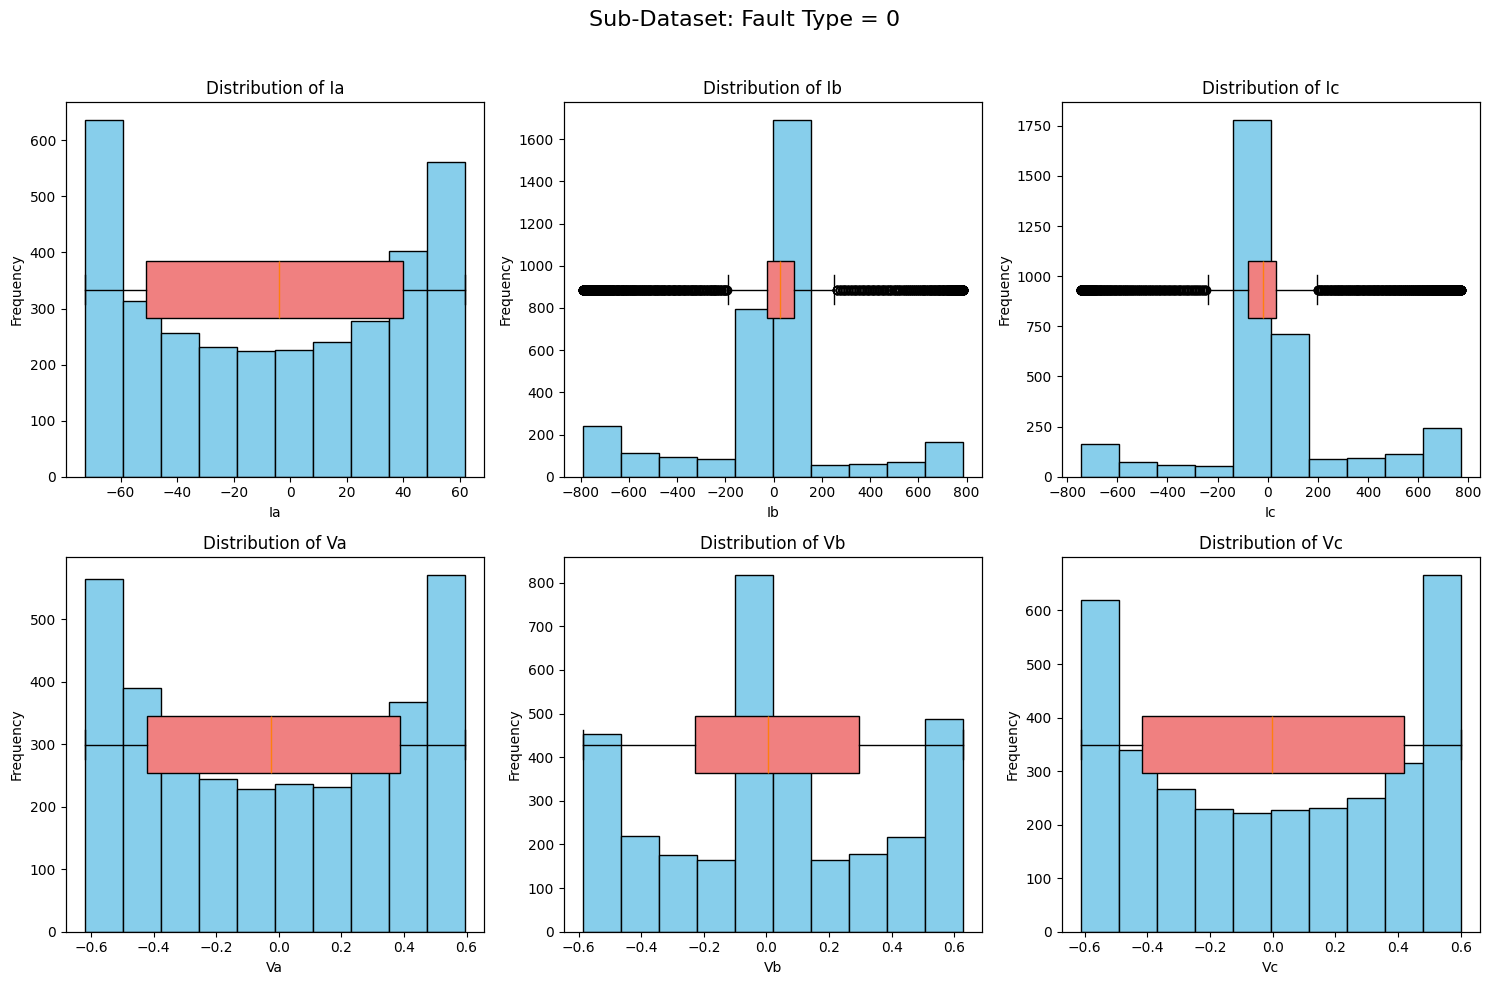

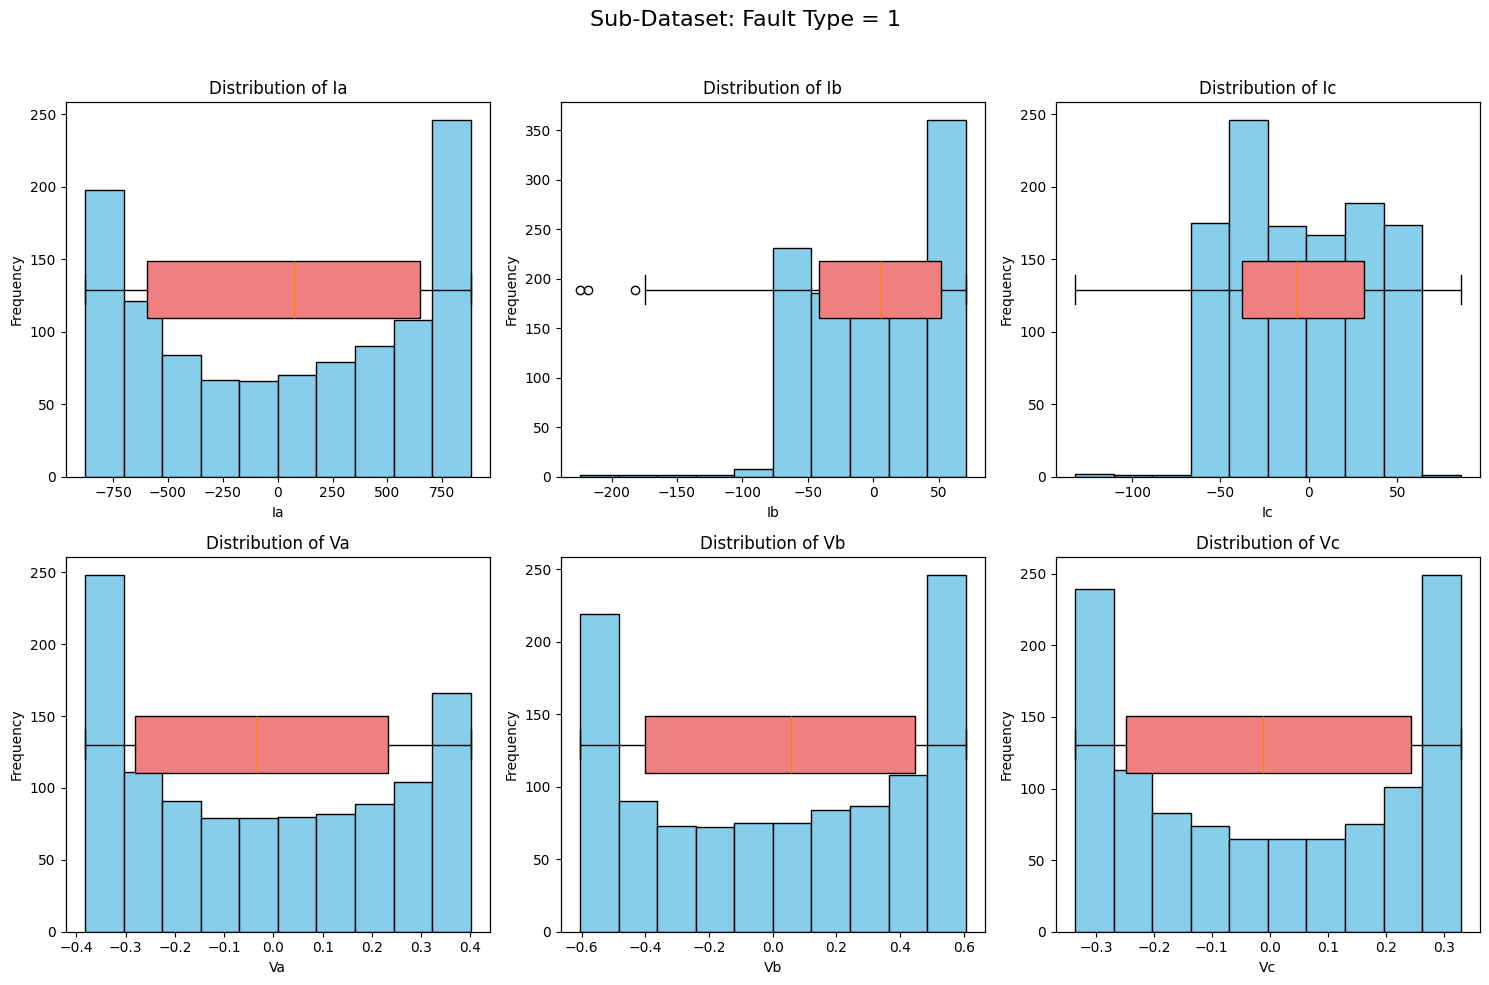

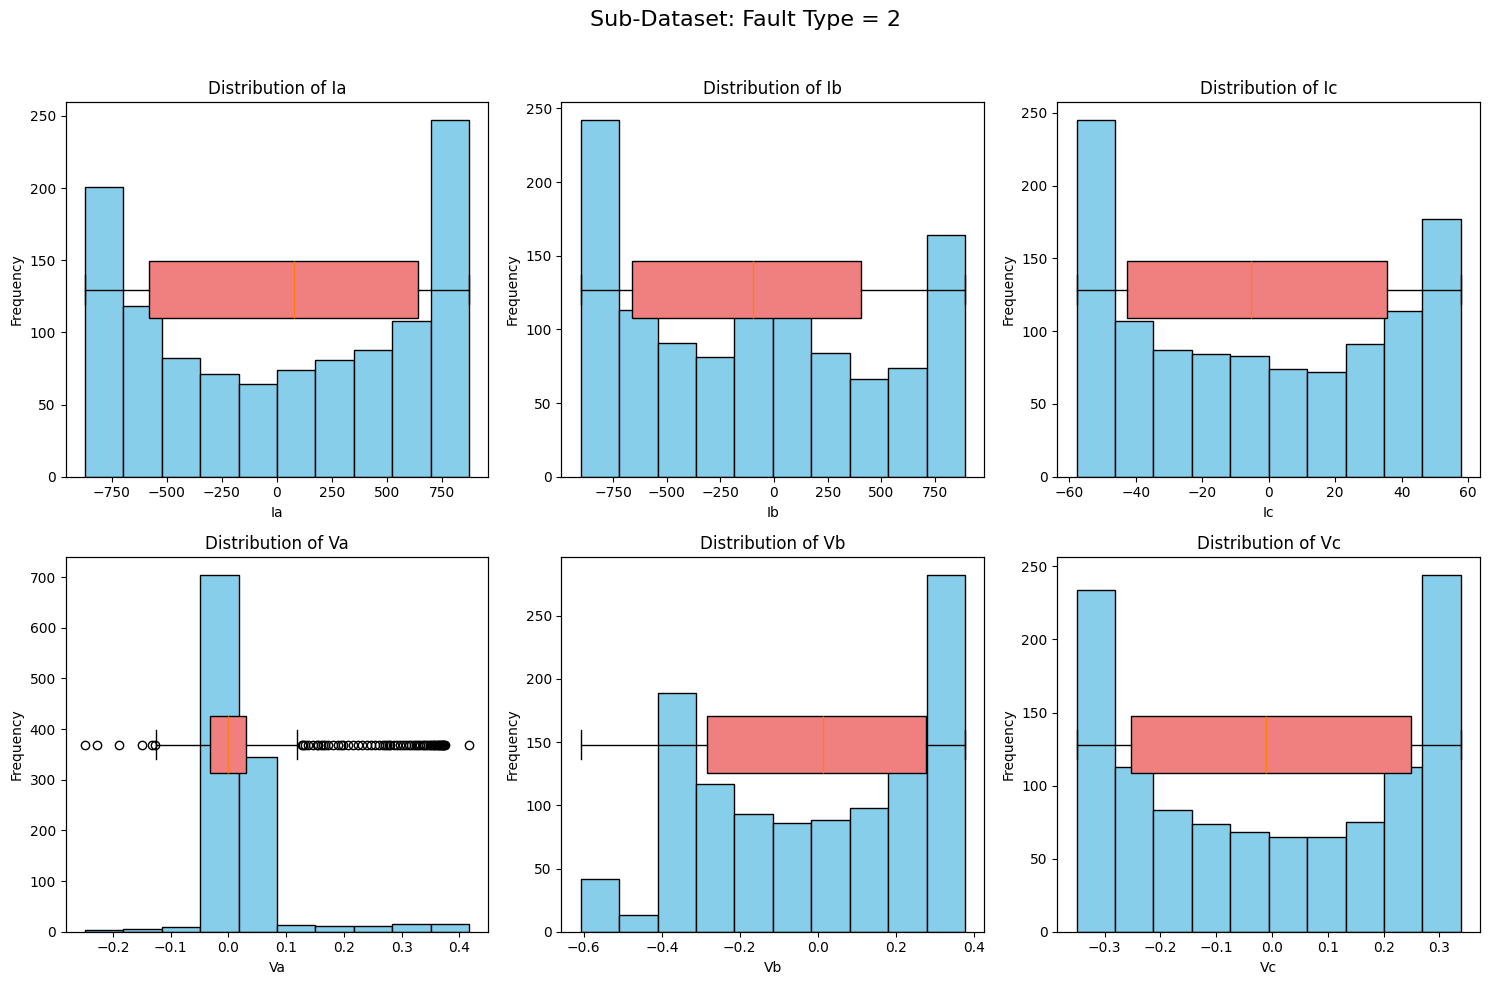

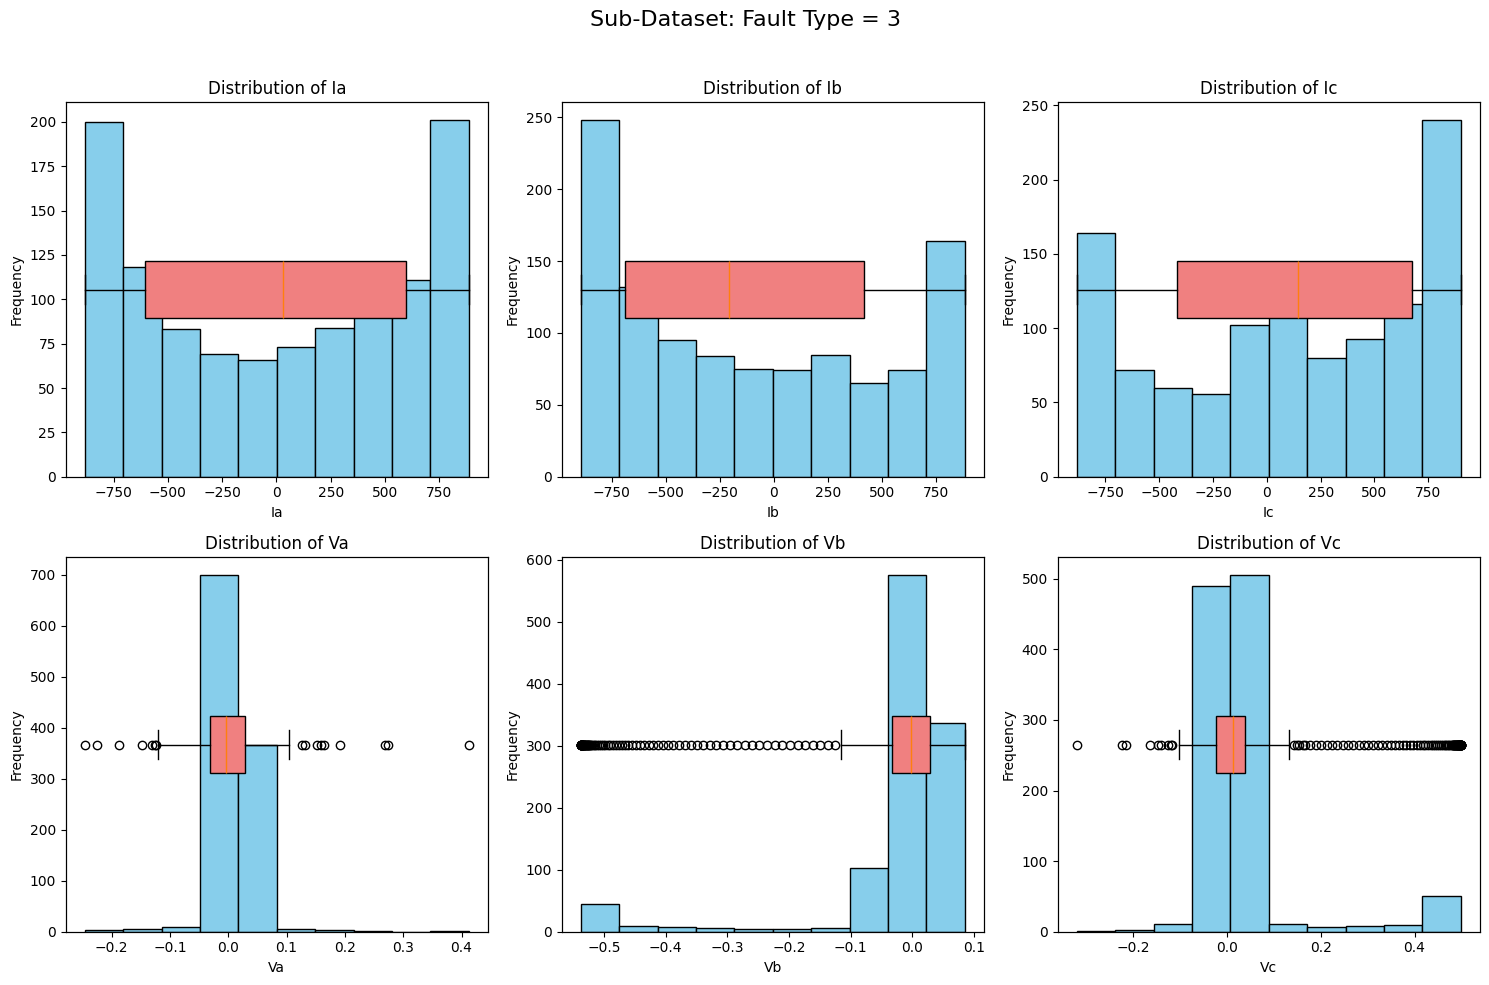

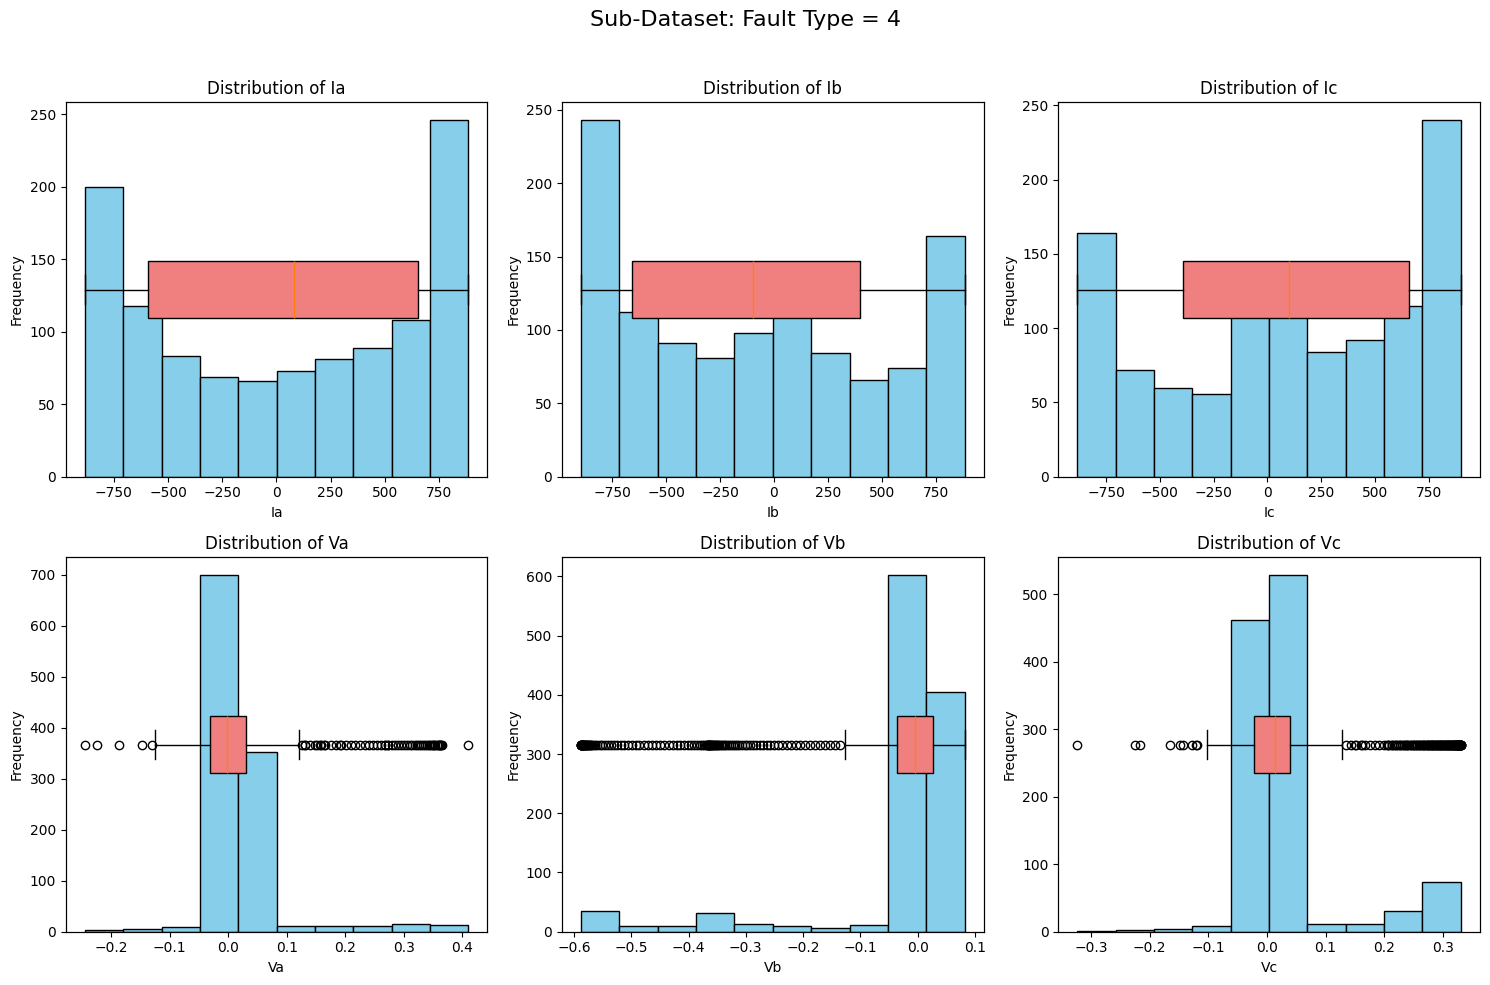

In [10]:
labels=dataset["FaultType"].unique()

for class_i in range(labels.max()+1):
    plotAttributeRanges(dataset.loc[dataset["FaultType"]==class_i], "Sub-Dataset: Fault Type = "+str(class_i),["FaultType"])

In [11]:
## There are some outlier in each class: the following procedure aims to remove all the data considered as outlier
## so that falls less or more then 1.5 x IQR.

In [12]:
# This function aims to remove all the outliers for all the attributes per class
# @param dataset: the dataset to use for remouving the outliers
# @param classAttribute: the attribute to consider as class
# @param listExcludedAttributes: list of all the attribute to exclude in the removal of the outliers
# @return the dataset modified without outliers 
def remove_outliers(dataset,classAttribute,listExcludedAttributes):

    labels=dataset[classAttribute].unique()

    for class_i in range(labels.max()+1):
        
        subDataset=dataset.loc[dataset[classAttribute]==class_i]
        #print(f"Class: {class_i}\n")
        
        for column in dataset.columns:
            if (column in listExcludedAttributes):
                continue

            Q1=subDataset[column].quantile(0.25)
            Q3=subDataset[column].quantile(0.75)

            # Calculate the IQR: Inter-Quantile Range
            IQR = Q3 - Q1

            # Define the lower and upper bounds for outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            #print(f"{column}: [{lower_bound} - {upper_bound}]")

            subDataset=subDataset.loc[(subDataset[column]>=lower_bound) & (subDataset[column]<=upper_bound)]
            
            dataset.drop(dataset[dataset.FaultType==class_i].index, inplace=True)
            dataset=pd.concat((dataset,subDataset))
            
    return dataset

In [ ]:
datasetWithoutOutliers=remove_outliers(dataset,"FaultType",["FaultType"])

#Print the new modified dataset
for class_i in range(labels.max()+1):
    plotAttributeRanges(datasetWithoutOutliers.loc[datasetWithoutOutliers["FaultType"]==class_i], "Sub-Dataset: Fault Type = "+str(class_i),["FaultType"])

In [14]:
datasetWithoutOutliers.describe()

,Ia,Ib,Ic,Va,Vb,Vc,FaultType
count,6698.000000,6698.000000,6698.000000,6698.000000,6698.000000,6698.000000,6698.000000
mean,0.264244,-30.116160,22.852190,-0.010764,0.017516,-0.006752,1.534339
std,488.693816,420.477030,345.622096,0.285768,0.326773,0.299860,1.480983
min,-883.542316,-900.526951,-883.357762,-0.620748,-0.605916,-0.612709,0.000000
25%,-283.049963,-81.815843,-57.721224,-0.092068,-0.177911,-0.214467,0.000000
50%,-5.123676,13.465652,-10.743655,-0.009524,0.008740,0.002825,1.000000
75%,279.303323,88.214100,37.289093,0.045529,0.245838,0.184553,3.000000
max,885.738571,889.868884,901.274261,0.595342,0.627875,0.600179,4.000000


#### Data rebalancing: obtain the same number of records per each class

In [31]:
# This function is used to plot a barchart for generic values.
# @param labels: the x-values to use on the x-axis
# @param values: the y-values to use on the y-axis
# @param x_label: the title to use on x-axis
# @param y_label: the title to use on y-axis
# @param title: the title to use on top of the graph
def plotBarChart(labels,values,x_label,y_label,title):
    x_pos = np.arange(len(labels))
    plt.bar(x_pos, values, align="center", alpha=0.5)
    
    plt.xticks(x_pos, labels)
    plt.ylabel(y_label)
    
    plt.xlabel(x_label)
    plt.title(title)

    for i in range(len(values)):
        plt.text(i, values[i] + max(values) * 0.001, str(values[i]), ha='center', va='bottom')

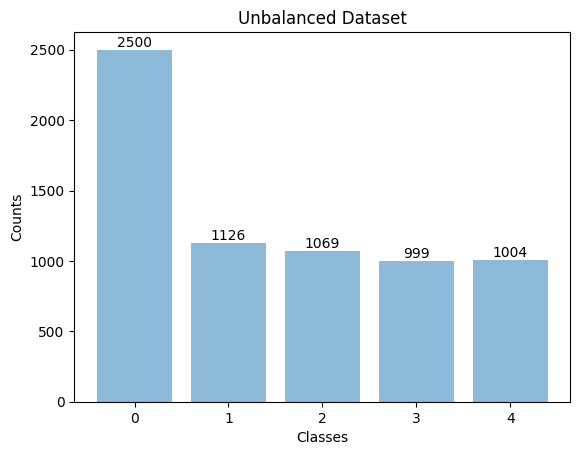

In [16]:
# Draw a plot to see if there is an imbalance dataset situation.
labels=datasetWithoutOutliers["FaultType"].unique()
labels.sort()
values=[ datasetWithoutOutliers.loc[datasetWithoutOutliers["FaultType"]==label]["FaultType"].count() for label in labels]

plotBarChart(labels,values,"Classes","Counts","Unbalanced Dataset")

In [17]:
#Undersampling taking as number of samples the class less populated
rebalancedDataset=datasetWithoutOutliers.loc[datasetWithoutOutliers["FaultType"]==0].sample(min(values))
rebalancedDataset=pd.concat((rebalancedDataset,datasetWithoutOutliers.loc[datasetWithoutOutliers["FaultType"]==1].sample(min(values))))
rebalancedDataset=pd.concat((rebalancedDataset,datasetWithoutOutliers.loc[datasetWithoutOutliers["FaultType"]==2].sample(min(values))))
rebalancedDataset=pd.concat((rebalancedDataset,datasetWithoutOutliers.loc[datasetWithoutOutliers["FaultType"]==3].sample(min(values))))
rebalancedDataset=pd.concat((rebalancedDataset,datasetWithoutOutliers.loc[datasetWithoutOutliers["FaultType"]==4].sample(min(values))))

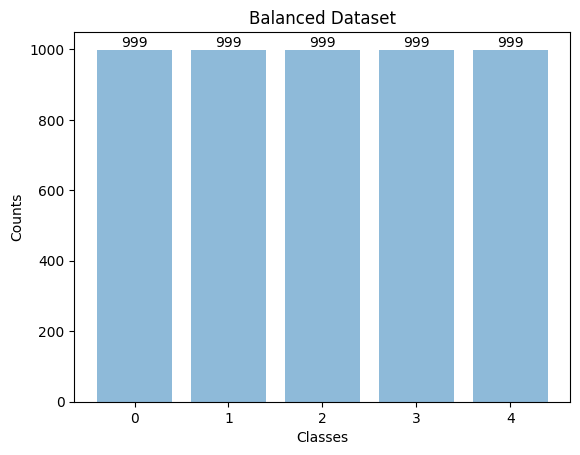

In [18]:
values=[ rebalancedDataset.loc[rebalancedDataset["FaultType"]==label]["FaultType"].count() for label in labels]
plotBarChartBalancing(labels,values,"Classes","Counts","Balanced Dataset")

In [19]:
rebalancedDataset.to_csv("Preproccessed_dataset.csv",index=False)
rebalancedDataset.describe()

,Ia,Ib,Ic,Va,Vb,Vc,FaultType
count,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000
mean,1.659897,-47.471052,39.082706,-0.006309,0.011203,-0.004895,2.000000
std,551.817969,478.167804,397.230361,0.228682,0.291522,0.248641,1.414355
min,-883.542316,-900.526951,-883.357762,-0.620371,-0.605916,-0.612573,0.000000
25%,-498.312335,-353.592979,-54.667235,-0.041027,-0.084762,-0.127049,1.000000
50%,-4.234479,-0.631499,-3.416520,-0.008647,0.005880,0.004442,2.000000
75%,488.452899,96.202719,54.009328,0.039092,0.150572,0.092634,3.000000
max,885.738571,889.868884,901.274261,0.595340,0.627875,0.600005,4.000000


### Data splitting: training and test data

In [20]:
#In this part the dataset is splitted in training (70%) and test(30%) mantaining the homogeneus number of classes per set.
#This is done in order to have the same test data for the next part in which different classifier are used.

In [2]:
#Used as checkpoint
rebalancedDataset=pd.read_csv("Preproccessed_dataset.csv")

In [22]:
from sklearn.model_selection import train_test_split

feature_cols = ['Ia', 'Ib', 'Ic', 'Va','Vb','Vc']
X = rebalancedDataset[feature_cols] 
Y = rebalancedDataset.FaultType

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,stratify=Y, random_state=44) # 80% training and 20% test

training_dataset = pd.concat([X_train, y_train], axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)

training_dataset.to_csv("training_dataset.csv",index=False)
test_dataset.to_csv("test_dataset.csv",index=False)

## Training a model

In [2]:
#Used as checkpoint - reload the dataset from external file

training_dataset=pd.read_csv("training_dataset.csv")
test_dataset=pd.read_csv("test_dataset.csv")

feature_cols = ['Ia', 'Ib', 'Ic', 'Va','Vb','Vc']

y_train=training_dataset["FaultType"]
X_train=training_dataset.drop('FaultType', axis=1)

y_test=test_dataset["FaultType"]
X_test=test_dataset.drop('FaultType', axis=1)

MODEL_DIRECTORY='models'

### Simple machine learning model: Decision Tree 

In [11]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score

In [4]:
## Used K-Cross Fold validation in order to use as much data as possible in training set.

In [9]:
# Create Decision Tree classifer 
clf = DecisionTreeClassifier(criterion="entropy")

# Set the number of folds and use the k-cross validation
k = 10 
scores = cross_val_score(clf, X_train, y_train, cv=k)

print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")
print(f"Standard deviation of accuracy: {scores.std():.2f}")

Cross-validation scores: [0.83       0.81       0.83       0.815      0.85       0.8375
 0.77443609 0.81203008 0.8245614  0.82957393]
Mean accuracy: 0.82
Standard deviation of accuracy: 0.02


In [10]:
#To test on specific test data, we need to train effectively the classifier with training data
clf = clf.fit(X_train,y_train)

#Execute inferring
y_pred = clf.predict(X_test)

In [11]:
print("Accuracy on test data:",metrics.accuracy_score(y_test, y_pred))

Accuracy on test data: 0.8328328328328328


In [12]:
# See what are the classes most miss-classified.
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Accuracy: ', accuracy)
print(report)

Accuracy:  0.8328328328328328
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       199
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00       200
           3       0.59      0.55      0.57       200
           4       0.58      0.62      0.60       200

    accuracy                           0.83       999
   macro avg       0.83      0.83      0.83       999
weighted avg       0.83      0.83      0.83       999



In [ ]:
#Explainability of the model: try to extrapolate the rules among the data.

In [ ]:
from sklearn.tree import export_graphviz #Used to convert a decision tree into a graph description language
from six import StringIO  
from IPython.display import Image  
import pydotplus

# Creates an in-memory file-like object, dot_data, to store the tree structure in dot format.
dot_data = StringIO()

# Extrapolation of the classifier and its rules.
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1','2','3','4'])

#Obatian the variable of the graph to work with.
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

graph.write_png('SmartTransformerRules.png')
Image(graph.create_png())

In [13]:
# Save the model into pickle file
with open(r"./"+MODEL_DIRECTORY+"/decision-tree-model.pickle", "wb") as fout:
    pickle.dump(clf, fout)
print(f"Object clf saved at decision-tree-model.pickle")

Object clf saved at decision-tree-model.pickle


### Advanced machine learning model: RandomForest

In [14]:
from sklearn.ensemble import RandomForestClassifier 

In [15]:
# Create Random Forest classifer 
rf_clf = RandomForestClassifier(n_estimators=100,criterion="entropy")

# Set the number of folds and use the k-cross validation
k = 10 
scores = cross_val_score(rf_clf, X_train, y_train, cv=k)

# Print the results
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")
print(f"Standard deviation of accuracy: {scores.std():.2f}")

Cross-validation scores: [0.7775     0.815      0.7975     0.8175     0.79       0.8225
 0.80451128 0.76441103 0.79197995 0.80701754]
Mean accuracy: 0.80
Standard deviation of accuracy: 0.02


In [20]:
#To test on specific test data, we need to train effectively the classifier with training data
rf_clf = rf_clf.fit(X_train,y_train)

#Execute inferring
y_pred = rf_clf.predict(X_test)

In [21]:
print("Accuracy on test data:",metrics.accuracy_score(y_test, y_pred))

Accuracy on test data: 0.8138138138138138


In [22]:
# See what are the classes most miss-classified.
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Accuracy: ', accuracy)
print(report)

Accuracy:  0.8138138138138138
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       199
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00       200
           3       0.53      0.55      0.54       200
           4       0.54      0.52      0.53       200

    accuracy                           0.81       999
   macro avg       0.81      0.81      0.81       999
weighted avg       0.81      0.81      0.81       999



In [23]:
# Save the model into pickle file
with open(r"random-forest-model.pickle", "wb") as fout:
    pickle.dump(rf_clf, fout)
print(f"Object clf saved at random-forest-model.pickle")

Object clf saved at random-forest-model.pickle


### Deep Learning model: simple feed forward neural network

In [4]:
import tensorflow as tf
import keras
import keras_tuner as kt
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-09-14 11:33:33.011566: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 11:33:36.862932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
#Adapt data to the format for neural network

#Create classes from the labels
train_labels = to_categorical(y_train)
train_features = np.array(X_train) # convert our dataframe into ndarray, only array type that neural network takes as input

test_labels = to_categorical(y_test)
test_features = np.array(X_test)

In [5]:
#Common parameters used in the training of neural network
EPOCHS=100
MAX_PATIENCE=20 # Nr of epoch in which no changes are on the monitored value

NB_classes = 5 #number of outputs
NB_features = 6 #number of inputs

In [6]:
#Function to plot custom graphics to see training performance
#xTra_scale range of values on x - training
#yTra_scale range of values on y - training
#xVal_scale range of values on x - validation
#yVal_scale range of values on y - validation
def plotAccuracyAndLossCurves(history,xTra_scale=np.arange(1, EPOCHS+1, 1),yTra_scale=np.arange(0, 1+0.05, 0.05),xVal_scale=np.arange(1, EPOCHS+1, 1),yVal_scale=np.arange(0, 1, 0.05)):
  plt.figure(figsize=(15,5))
  
  #On training set
  acc_1 = history['accuracy']
  loss_1 = history['loss']
  
  #On validation set
  val_acc_1 = history['val_accuracy']
  val_loss_1 = history['val_loss']

  #History length
  n_epochs=len(historySaved['accuracy'])
  
  epochs = np.arange(1, n_epochs+1, 1)
  plt.grid()
  plt.plot(epochs, acc_1, 'b-', label='Training accuracy')
  plt.plot(epochs, val_acc_1, 'r-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.xticks(xTra_scale)
  plt.yticks(yTra_scale)
  plt.figure()

  plt.figure(figsize=(15,5))
  plt.plot(epochs, loss_1, 'b-', label='Training loss')
  plt.plot(epochs, val_loss_1, 'r-', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xticks(xVal_scale)
  plt.yticks(yVal_scale)
  plt.legend()
  plt.grid()

  plt.show()

In [7]:
# This custom callback is created to save at checkpoints the best model obtained so far. In addition it is invocked a EarlyStopping function to avoid
# to continue the training if no improvement are achieved.
# @param save_path: the location where the checkpoint is saved
# @param val_to_monitor: the value to consider as improved or not
# @param patience: the number of epoch to tolerate without any improvement
def createCustomCallback(save_path,val_to_monitor,patience):
  return [
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor=val_to_monitor,
    verbose=1,
    save_best_only=True #Save best model only
    ),
    keras.callbacks.EarlyStopping(monitor=val_to_monitor, patience=patience,restore_best_weights=True)
  ]
    
custom_callback=createCustomCallback('./'+MODEL_DIRECTORY+'/best_model_nn.keras','val_loss',MAX_PATIENCE)

Execute a grid search to determine a possibile set of parameter to use in the neural network

In [8]:
# Definition of the parametric model: 2 layers with variable number of neurons; variable lerning rate and different activation functions.
# @param implicit variable used to create ranges of hyperparameters
# @return the parametric model to train
def model_builder(hp):

  # Choose an optimal value between 32-256 - first layer
  hp_units_1 = hp.Int('units_first_layer', min_value=32, max_value=256, step=32)

  # Choose an optimal value between 256-512  second layer
  hp_units_2 = hp.Int('units_second_layer', min_value=256, max_value=512, step=32)

  # Choose an optimal value from 0.01, 0.01, 0.001, 0.0001,0.00005, 0.00001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3 , 1e-4, 5e-5,1e-5])
 
  # Choose an optimal value from relu, hyperbolic-tanget and sigmoid
  hp_activation_function = hp.Choice('activation', values=['relu' ,'tanh', 'sigmoid'])

  model = keras.Sequential()
  model.add(keras.layers.Dense(units=hp_units_1, activation=hp_activation_function,input_shape=(NB_features,)))
  model.add(keras.layers.Dense(units=hp_units_2, activation=hp_activation_function))
  model.add(keras.layers.Dense(NB_classes, activation=tf.keras.activations.softmax))

  # Tune the learning rate for the optimizer
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [9]:
#Initizalization of the random search
tuner = kt.RandomSearch(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     directory='./'+MODEL_DIRECTORY,
                     project_name='testKerasTuner')

#Start the search
tuner.search(train_features, train_labels, epochs=EPOCHS, validation_split=0.2, callbacks=[custom_callback])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. \n \
        The optimal number of units in the first densely-connected layer is {best_hps.get('units_first_layer')} \n \
        The optimal number of units in the second densely-connected layer is {best_hps.get('units_second_layer')} \n \
        the optimal learning rate for the optimizer is {best_hps.get('learning_rate')} \n \
        the optimal activation function to be used is {best_hps.get('activation')}.")

Trial 10 Complete [00h 00m 35s]
val_accuracy: 0.8999999761581421

Best val_accuracy So Far: 0.9637500047683716
Total elapsed time: 00h 04m 37s
The hyperparameter search is complete. 
         The optimal number of units in the first densely-connected layer is 64 
         The optimal number of units in the second densely-connected layer is 384 
         the optimal learning rate for the optimizer is 0.0001 
         the optimal activation function to be used is tanh.


In [10]:
#Build the effective model and visualize it
model = tuner.hypermodel.build(best_hps)
model.summary() #to see the paramter of our model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 384)            │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,925 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,333 (106.77 KB)

 Trainable params: 27,333 (106.77 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#Train the model
history=model.fit(x=train_features,
          y=train_labels,
          epochs=EPOCHS,
          validation_split=0.2,
          callbacks = custom_callback,
          verbose=1,
          shuffle=True) #Train our model

#Save history obtained in history folder
with open('./history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2911 - loss: 1.6261
Epoch 1: val_loss improved from inf to 1.59967, saving model to ./models/nn_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2914 - loss: 1.6259 - val_accuracy: 0.3438 - val_loss: 1.5997
Epoch 2/100
 87/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3407 - loss: 1.5895
Epoch 2: val_loss improved from 1.59967 to 1.57933, saving model to ./models/nn_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3429 - loss: 1.5877 - val_accuracy: 0.3300 - val_loss: 1.5793
Epoch 3/100
 89/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3679 - loss: 1.5691
Epoch 3: val_loss improved from 1.57933 to 1.57516, saving model to ./models/nn_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3696 - loss: 1.5680 - val_accuracy: 0.3262 - val_loss: 1.5752
Epoch 4/100
 88/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3654 - loss: 1.5516
Epoch 4: val

In [12]:
performance=model.evaluate(test_features,test_labels, verbose=0 )[1] * 100
print('Final accuracy : ', round(performance), '%')

Final accuracy :  99 %


In [15]:
model.save('./'+MODEL_DIRECTORY+'/best_model_nn.keras')

In [ ]:
model = load_model('./'+MODEL_DIRECTORY+'/best_model_nn.keras') 

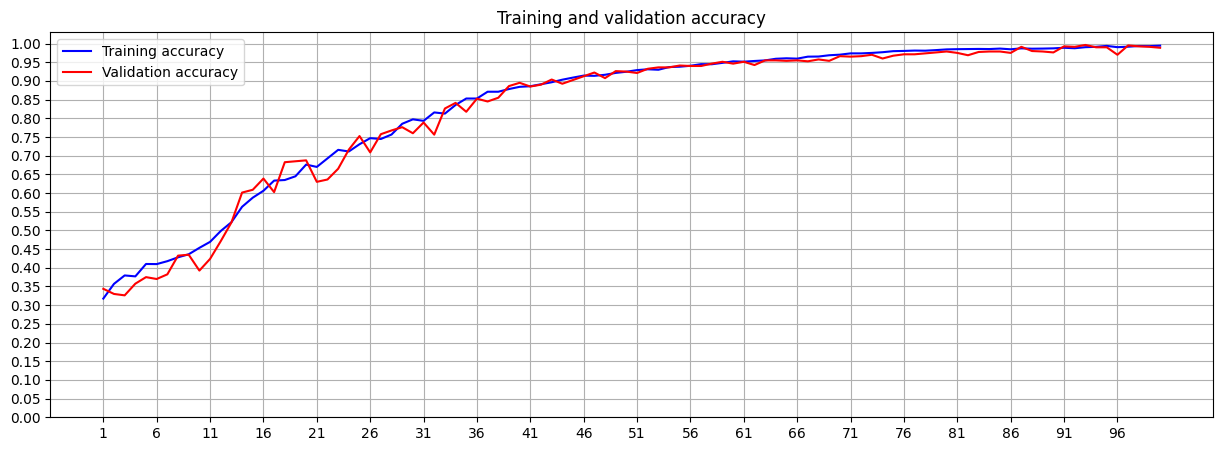

<Figure size 640x480 with 0 Axes>

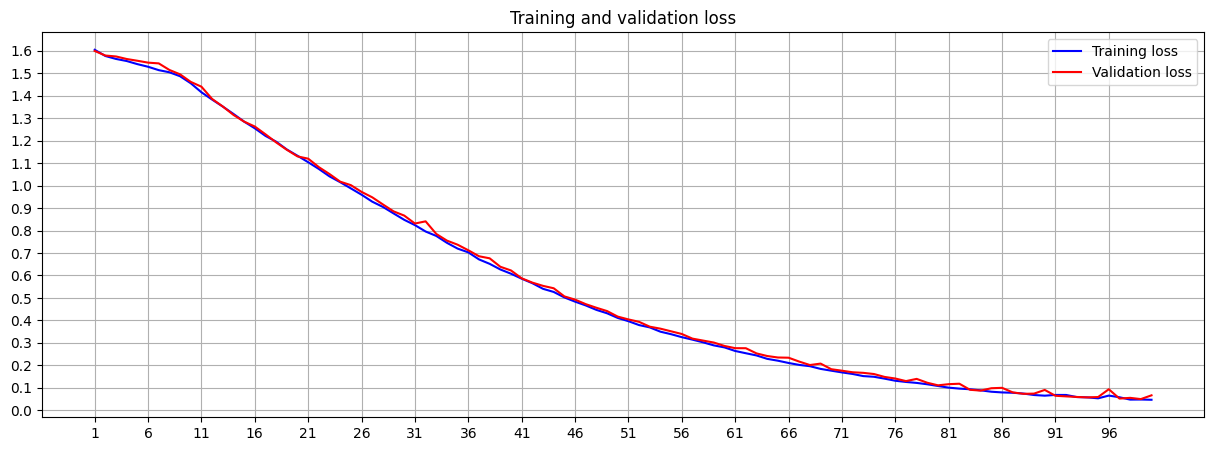

In [14]:
# Plot the history graph
#Reload the history in a further moment and plot the graphics

with open('./history', "rb") as file_pi:
    historySaved = pickle.load(file_pi) 
plotAccuracyAndLossCurves(historySaved,np.arange(1, EPOCHS+1, 5),np.arange(0, 1+0.05, 0.05),np.arange(1, EPOCHS, 5),np.arange(0, 1.7, 0.1))

### Selection of the model

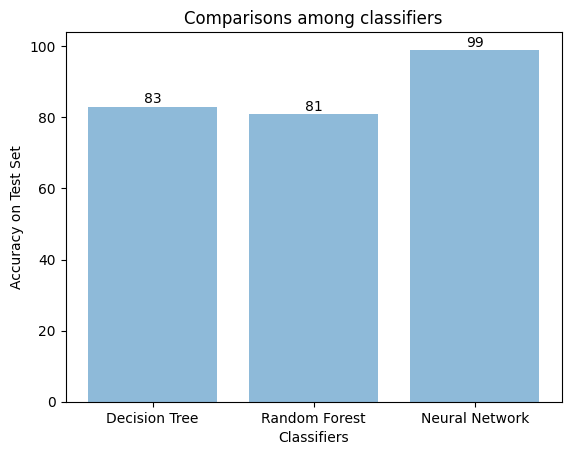

In [32]:
plotBarChart(["Decision Tree","Random Forest","Neural Network"],[83,81,99],"Classifiers","Accuracy on Test Set","Comparisons among classifiers")

In [ ]:
#Althougth it is a little bit more complex and heavyer, the neural network is the best choice for this task.

In [6]:
MODEL_DIRECTORY='models'
model = load_model('./'+MODEL_DIRECTORY+'/best_model_nn.keras') 

## Converting the model for IoT device

In [16]:
import emlearn

path = './'+MODEL_DIRECTORY+'/smart_transformer_fault_detection.h'

cmodel = emlearn.convert(model, method='inline')

cmodel.save(file=path, name='smart_transformer_fault_detection')

print('Wrote model to', path)

In file included from /home/davide/.local/lib/python3.10/site-packages/emlearn/eml_net.h:6,
                 from tmp/mynet.h:2,
                 from tmp/mynet.c:2:
/home/davide/.local/lib/python3.10/site-packages/emlearn/eml_net_common.h:18:1: warning: ‘eml_net_activation_function_strs’ defined but not used [-Wunused-variable]
   18 | eml_net_activation_function_strs[EmlNetActivationFunctions] = {
      | ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Wrote model to ./models/smart_transformer_fault_detection.h


In [ ]:
#Test predictions
#test_data=np.array([5.75,34.82,-35.75,-0.2,0.35,-0.4]).reshape(1,6)
#a=model.predict(test_data)
#np.argmax(a[0])
#test_features[0]

In [8]:
test_data=np.array([24.50,-34.91,22.30,0.58,-0.32,-0.26]).reshape(1,6)
a=model.predict(test_data)

np.argmax(a[0])
#test_features[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


0